# Getting started with `JaxILI`

`JaxILI` is a python package powered in `JAX` to perform Neural Density Estimation. It provides a user-friendly interface to run state-of-the-art algorithms of *Implicit Likelihood Inference* (ILI) also called *Simulation-based inference* or *Likelihood-free inference*.

In this tutorial, we show how to get started with `JaxILI` to perform parameter inference on a simple toy model.

In [1]:
import os

import jax
import jax.numpy as jnp
import numpy as np

from jaxili.inference import NPE
from jaxili.model import ConditionalRealNVP

print("Device used by jax:", jax.devices())

2025-03-12 20:06:09.092790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741806369.169011    6773 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741806369.189050    6773 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Device used by jax: [CudaDevice(id=0)]


## Implicit Likelihood Inference in a nutshell

Any Implicit Likelihood Inference algorithm requires three things:
- An observational data $x_{\rm obs}$ depending on some parameters $\theta$.
- A (stochastic) mechanistic model that samples the observation given the parameters: $x_{\rm obs} \sim p(x|\theta)$. We will refer to it as the *simulator*.
- A prior knowledge of the parameters: $p(\theta)$.

According to Bayes theorem:

$$
p(\theta|x)\propto p(x|\theta)p(\theta)
$$

Thus, estimating the value of the parameters conditioned on some observational data $x_{\rm obs}$ targets the posterior distribution $p(\theta|x_{\rm obs})$. This can be done using Neural Posterior Estimation trained on the simulator output. If you are new to Implicit Likelihood Inference, please check the [user guide]() (TBD) to familiarize yourself with the theory behind Implicit Likelihood Inference.

## The linear Gaussian example

This illustrative example considers a *simulator* that takes 3 parameters $\theta$ in input. The likelihood modeled by the simulator follows a simple Gaussian distribution:

$$
x|\theta \sim \mathcal{N}(m_{\theta} = \theta, S=0.1 \odot I)
$$

This standard problem is part of the *SBI benchmark* done in [Lueckmann et al.](https://arxiv.org/abs/2101.04653). For the sake of simplicity, we will here reduce the dimensionality from $n=10$ to $n=3$. We will consider a uniform prior between -2 and 2: $\mathcal{U}(-2, 2).

Let's first define the simulator:

In [2]:
n_dim = 3

def simulator(theta, rng_key):
    batch_size = theta.shape[0]
    return theta + jax.random.normal(rng_key, shape=(batch_size, n_dim))*0.1

### Creating the dataset

We can first draw parameters from the prior to create a dataset of pairs $(\theta_n, x_n)_n$.

In [3]:
master_key = jax.random.PRNGKey(0)
num_samples = 10_000

theta_key, master_key = jax.random.split(master_key)

#Draw the parameters from the prior
theta = jax.random.uniform(theta_key, shape=(num_samples, n_dim), minval=jnp.array([-2., -2., -2.]), maxval=jnp.array([2., 2., 2.]))

sim_key, master_key = jax.random.split(master_key)
x = simulator(theta, sim_key)

In [4]:
print("Parameters shape:", theta.shape)
print("Data shape:", x.shape)

Parameters shape: (10000, 3)
Data shape: (10000, 3)


### Creating the trainer and loading the simulations

We then need to instantiate an inference object. In this example, we will use Neural Posterior Estimation (NPE).

In [5]:
inference = NPE()

We then need to push the simulations in the inference object.

In [6]:
inference = inference.append_simulations(theta, x)

[!] Inputs are valid.
[!] Appending 10000 simulations to the dataset.


[!] Dataset split into training, validation and test sets.
[!] Training set: 7000 simulations.
[!] Validation set: 2000 simulations.
[!] Test set: 1000 simulations.


### Training

We can then start to train a Normalizing flow to learn the posterior. A default setup for the training hyperparameters and the model is already in place but it will be shown in other examples (TBD) how to do it.

In [7]:
#Specify a checkpoint to save the weights of the neural network
CHECKPOINT_PATH = "."
#Turn it into an absolut path
CHECKPOINT_PATH = os.path.abspath(CHECKPOINT_PATH)

num_epochs = 500

metrics, density_estimator = inference.train(
    checkpoint_path=CHECKPOINT_PATH,
    num_epochs=num_epochs,
)

[!] Creating DataLoaders with batch_size 50.
[!] Building the neural network.
[!] Creating the Trainer module.
Could not tabulate model: 


[!] Training the density estimator.


Epochs: Val loss -2.643/ Best val loss -2.693:   8%|▊         | 41/500 [00:27<05:12,  1.47it/s] 

Neural network training stopped after 42 epochs.
Early stopping with best validation metric: -2.6933953762054443
Best model saved at epoch 21
Early stopping parameters: min_delta=0.001, patience=20
[!] Training loss: -2.6592743396759033
[!] Validation loss: -2.6933953762054443
[!] Test loss: -2.6007096767425537


### Building the posterior and evaluating

In [8]:
posterior = inference.build_posterior()

[!] Posterior $p(\theta| x)$ built. The class DirectPosterior is used to sample and evaluate the log probability.


We can then directly sample the parameters using the learned distirbution by the Neural Density Estimator.

In [9]:
#Let's first create an observation
obs_key, master_key = jax.random.split(master_key)
fiducial = jnp.array([[0.5, 0.5, 0.5]])
obs = simulator(fiducial, obs_key)

num_samples = 10_000
sample_key, master_key = jax.random.split(master_key)
samples = posterior.sample(
    x=obs, num_samples=num_samples, key=sample_key
)

### Visualisation of the learned posterior

In [10]:
#We will use getdist to visualise the results
import matplotlib.pyplot as plt
from getdist import plots, MCSamples
%matplotlib inline

Removed no burn in


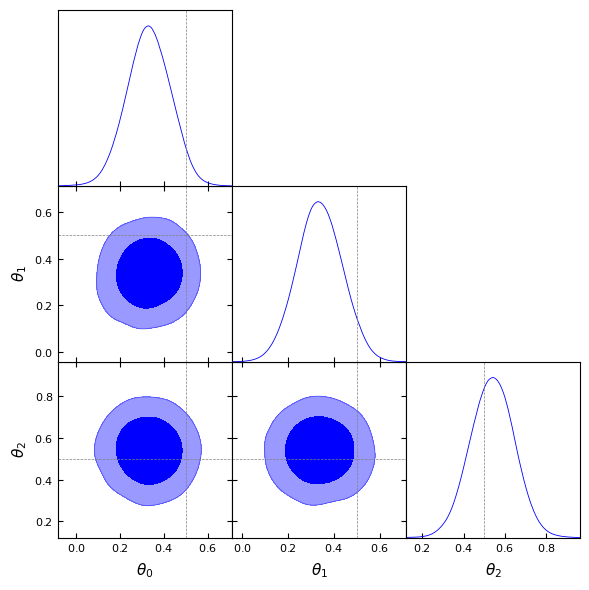

In [11]:
labels = [rf'\theta_{i}' for i in range(n_dim)]

samples_gd = MCSamples(samples=samples, names=labels, labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([samples_gd], filled=True,
                line_args=[
                    {'color': 'blue'}
                ],
                contour_colors=['blue'],
                markers={
                    label: val for label, val in zip(labels, fiducial[0])
                })

plt.show()

Because of the noise in the simulator and the absence of hyperparameters fine-tuning, it is possible that the ground-truth does not lie at the center of the posterior. This is why it is useful to assess the predictive performance of the psoterior.

In [12]:
predictive_key, master_key = jax.random.split(master_key)
x_predictive = simulator(samples, predictive_key)

Removed no burn in


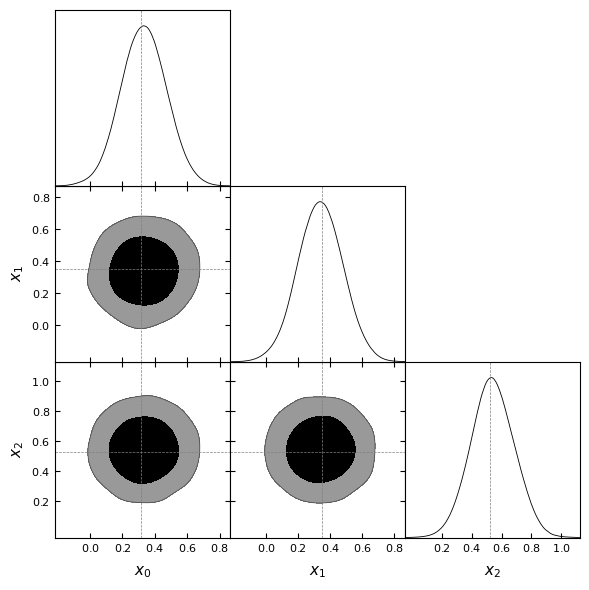

In [13]:
labels = [rf'x_{i}' for i in range(n_dim)]

predictive_samples_gd = MCSamples(samples=x_predictive, names=labels, labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([predictive_samples_gd], filled=True,
                line_args=[
                    {'color': 'black'}
                ],
                contour_colors=['black'],
                markers={
                    label: val for label, val in zip(labels, obs[0])
                })

plt.show()

We can see that the posterior predicted is correctly centered on the data. A nice thing about Implicit Likelihood Inference is that the inference is said to be *amortiez*. It means that the trained network can be used on a different observation without going through the whole training procedure.

In [14]:
obs_key, master_key = jax.random.split(master_key)
fiducial_2 = jnp.array([[1.5, 1.5, 1.5]])
obs_2 = simulator(fiducial_2, obs_key)

sample_key, master_key = jax.random.split(master_key)
samples_2 = posterior.sample(
    x=obs_2, num_samples=num_samples, key=sample_key
)

Removed no burn in


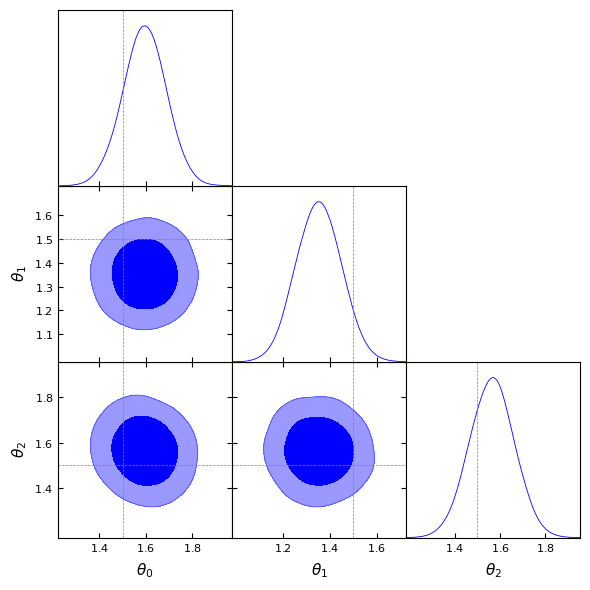

In [15]:
labels = [rf'\theta_{i}' for i in range(n_dim)]

samples_2_gd = MCSamples(samples=samples_2, names=labels, labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([samples_2_gd], filled=True,
                line_args=[
                    {'color': 'blue'}
                ],
                contour_colors=['blue'],
                markers={
                    label: val for label, val in zip(labels, fiducial_2[0])
                })

plt.show()

In [16]:
predictive_key, master_key = jax.random.split(master_key)
x_predictive_2 = simulator(samples_2, predictive_key)

Removed no burn in


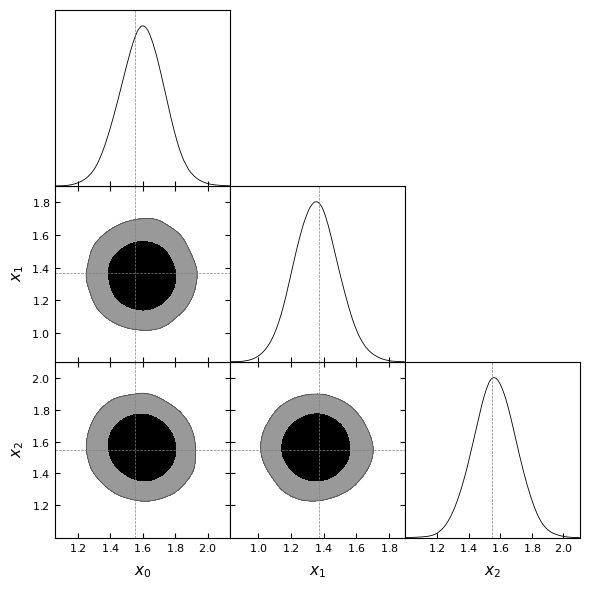

In [17]:
labels = [rf'x_{i}' for i in range(n_dim)]

predictive_samples_2_gd = MCSamples(samples=x_predictive_2, names=labels, labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([predictive_samples_2_gd], filled=True,
                line_args=[
                    {'color': 'black'}
                ],
                contour_colors=['black'],
                markers={
                    label: val for label, val in zip(labels, obs_2[0])
                })

plt.show()

## Using a non-default architecture

When creating the `inference` object, it is possible to choose the architecture of the Normalizing Flow you want to use as well as its hyperparameters.

In [18]:
model_class = ConditionalRealNVP
model_hparams = {
    "n_in": n_dim,
    "n_cond": n_dim,
    "n_layers": 3,
    "layers": [50, 50],
    "activation": jax.nn.relu
}

inference = NPE(model_class=model_class, model_hparams=model_hparams)

inference = inference.append_simulations(theta, x)

#Specify a checkpoint to save the weights of the neural network
CHECKPOINT_PATH = "."
#Turn it into an absolut path
CHECKPOINT_PATH = os.path.abspath(CHECKPOINT_PATH)

num_epochs = 500

metrics, density_estimator = inference.train(
    checkpoint_path=CHECKPOINT_PATH,
    num_epochs=num_epochs,
)

[!] Inputs are valid.
[!] Appending 10000 simulations to the dataset.
[!] Dataset split into training, validation and test sets.
[!] Training set: 7000 simulations.
[!] Validation set: 2000 simulations.
[!] Test set: 1000 simulations.
[!] Creating DataLoaders with batch_size 50.
[!] Building the neural network.
[!] Creating the Trainer module.
Could not tabulate model: float() argument must be a string or a real number, not '_ArrayRepresentation'


[!] Training the density estimator.


Epochs: Val loss -2.618/ Best val loss -2.634:  28%|██▊       | 139/500 [02:32<06:34,  1.09s/it]

Neural network training stopped after 140 epochs.
Early stopping with best validation metric: -2.6341469287872314
Best model saved at epoch 119
Early stopping parameters: min_delta=0.001, patience=20
[!] Training loss: -2.68935227394104
[!] Validation loss: -2.6341469287872314
[!] Test loss: -2.7200582027435303


In [19]:
posterior = inference.build_posterior()

[!] Posterior $p(\theta| x)$ built. The class DirectPosterior is used to sample and evaluate the log probability.


In [20]:
num_samples = 10_000
sample_key, master_key = jax.random.split(master_key)
samples = posterior.sample(
    x=obs, num_samples=num_samples, key=sample_key
)

Removed no burn in


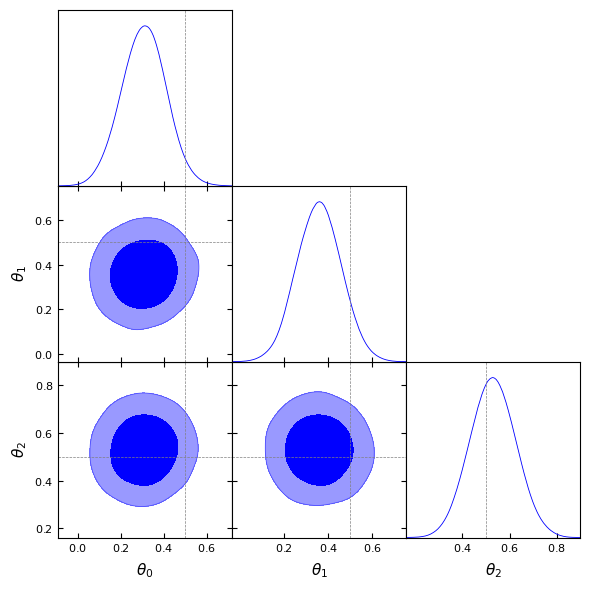

In [21]:
labels = [rf'\theta_{i}' for i in range(n_dim)]

samples_gd = MCSamples(samples=samples, names=labels, labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([samples_gd], filled=True,
                line_args=[
                    {'color': 'blue'}
                ],
                contour_colors=['blue'],
                markers={
                    label: val for label, val in zip(labels, fiducial[0])
                })

plt.show()

In [22]:
predictive_key, master_key = jax.random.split(master_key)
x_predictive = simulator(samples, predictive_key)

Removed no burn in


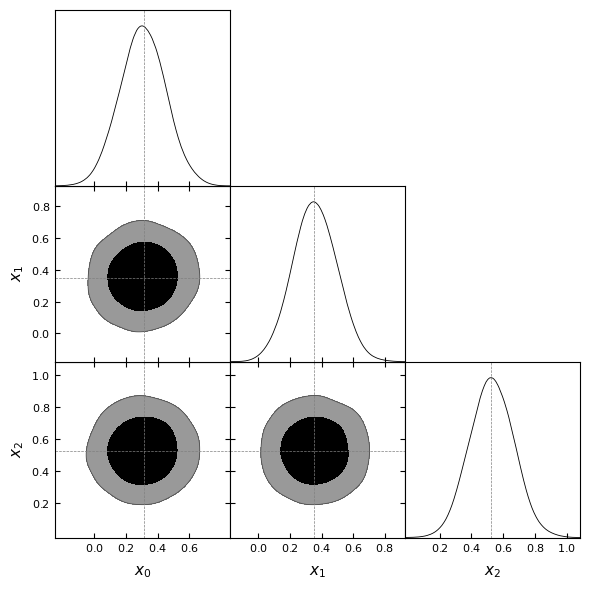

In [23]:
labels = [rf'x_{i}' for i in range(n_dim)]

predictive_samples_gd = MCSamples(samples=x_predictive, names=labels, labels=labels)

g = plots.get_subplot_plotter()

g.settings.figure_legend_frame = False
g.settings.alpha_filled_add = 0.4

g.triangle_plot([predictive_samples_gd], filled=True,
                line_args=[
                    {'color': 'black'}
                ],
                contour_colors=['black'],
                markers={
                    label: val for label, val in zip(labels, obs[0])
                })

plt.show()

## Next steps

TBD.